<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFE_numba_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
!pip install memory_profiler

CPU times: user 170 ms, sys: 38.9 ms, total: 208 ms
Wall time: 26 s


In [2]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

TensorFlow 2.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%time
import datetime
import glob
from math import sqrt
import os
import matplotlib.pyplot as plt
import bokeh
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Point
import networkx as nx
from sys import getsizeof
from numba import jit
import dask.dataframe as dd
import dask.array as da
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
%matplotlib inline
%load_ext memory_profiler

pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 730 ms, sys: 68.2 ms, total: 798 ms
Wall time: 818 ms


In [4]:
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/3061/1,Cluster Workers: 1 Cores: 2 Memory: 13.66 GB


Set up the path  to data and output

In [5]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
path_output = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output'

!ls "/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input"
!ls '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output/dask_edge_list'

buildings_raw.cpg      buildings_raw_pts.mshp  buildings_raw.shp
buildings_raw.dbf      buildings_raw_pts.prj   buildings_raw.shx
buildings_raw.prj      buildings_raw_pts.shp   GD_wind.csv
buildings_raw_pts.cpg  buildings_raw_pts.shx   source_target.csv
buildings_raw_pts.dbf  buildings_raw.qpj
edge_data.parquet


Create the functions to be used by the algorithm

In [0]:
# wind scenario
def wind_scenario(file_name):
    # wind scenario conditions
    wind_data = pd.read_csv(os.path.join(path, file_name))
    i = np.random.randint(0, wind_data.shape[0])
    w = wind_data.iloc[i, 2]
    d = wind_data.iloc[i, 1]
    b = wind_data.iloc[i, 3]
    # wind direction
    wind_bearing_max = b + 45
    wind_bearing_min = b - 45
    if b == 360:
        wind_bearing_max = 45
    if b <= 0:  # should not be necessary
        wind_bearing_min = 0
    if b == 999:
        wind_bearing_max = 999
        wind_bearing_min = 0
    
    return wind_bearing_max, wind_bearing_min, d

In [0]:
# create ignitions
def ignitions(edges, scenario):
    # add random column
    edges['rng'] = np.random.uniform(0, 1, size=len(edges))
    # filter on random column
    fires = edges[edges.rng < edges.IgnProb_bl] # <------ correct this line, not seen by algo ...
    # print("ignition fires : {}".format(fires[['rng', 'IgnProb_bl']]))

    fires['step'] = 0
    fires['scenario'] = scenario

    return fires

In [0]:
# burned assets
def record_burnt_assets(burn, fires):
  data = [fires, burn]
  burnt = pd.concat(data, axis=0)
  return burnt

In [0]:
# conditions of fire propagation
def conditions_spread(fires,burn,wind_bearing_max,wind_bearing_min,wind_distance,
                      scenario, step):
    # add columns to ddf
    fires['wind_bearing_max'] = wind_bearing_max
    fires['wind_bearing_min'] = wind_bearing_min
    fires['wind_distance'] = wind_distance
    # wind speed -> neighbors selection from wind buffer
    new_fires = fires[fires.distance < fires.wind_distance]
    # wind direction
    new_fires = new_fires[(new_fires.bearing < new_fires.wind_bearing_max) & (new_fires.bearing < new_fires.wind_bearing_min)]
    # should not be already burnt
    burn_list = list(set(burn.source))
    new_fires = new_fires[~new_fires.target.isin(burn_list)]
    # burn_list.append(fires.source)

    new_fires['step'] = step
    new_fires['scenario'] = scenario

    # log burnt assets
    BURNED = record_burnt_assets(burn, fires)
    return new_fires, BURNED

In [0]:
# spreading fire
def new_fires(fires, edges):
  fires_list = list(set(fires.target))
  new_fires = edges[edges.source.isin(fires_list)]
  return new_fires

In [0]:
# display network
def display_network(edge_list_dataframe):
    graph = nx.from_pandas_edgelist(edge_list_dataframe, edge_attr=True)
    options = {'node_color': 'red', 'node_size': 50, 'width': 1, 'alpha': 0.4,
               'with_labels': False, 'font_weight': 'bold'}
    nx.draw_kamada_kawai(graph, **options)
    plt.show()
    return graph

peak memory: 410.07 MiB, increment: 0.07 MiB
number of edges : 27620


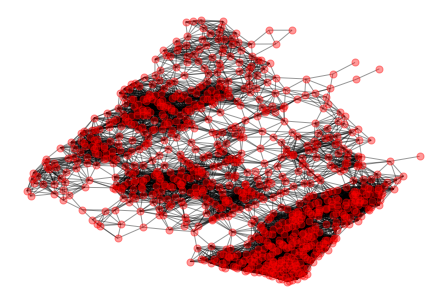

CPU times: user 16.1 s, sys: 387 ms, total: 16.5 s
Wall time: 16.3 s


In [33]:
%%time
%memit
# with ProgressBar():
# load data
# EDGES = dd.read_parquet(os.path.join(path_output, 'dask_edge_list', 'edge_data.parquet'), engine='pyarrow')
EDGES = pd.read_parquet(os.path.join(path_output, 'dask_edge_list', 'edge_data.parquet'), engine='pyarrow')
print("number of edges : {}".format(len(EDGES)))

G = display_network(EDGES)

In [0]:
# run main
def main(number_of_scenarios, edges):
  list_BURNED = []
  # --- SCENARIOS
  print("number of scenarios : {}".format(number_of_scenarios))
  for scenario in range(number_of_scenarios):
      BURNED = pd.DataFrame(columns=['source','target','distance', 'bearing',
                                      'IgnProb_bl', 'scenario', 'step'])
      print("--- SCENARIO : {}".format(scenario))
      FIRES = ignitions(EDGES, scenario)
      # print("ignitions FIRES : {}".format(FIRES))
      if len(FIRES) == 0:
          print("no fire")
          continue
      wind_bearing_max, wind_bearing_min, wind_distance = wind_scenario('GD_wind.csv') # no filtering, just adding wind info to dataframe
      # --------- STEPS
      for step in range(len(EDGES)):
          print("--------- STEP : {}".format(step))
          # print("# of FIRES : {}".format(len(FIRES)))
          FIRES, BURNED = conditions_spread(FIRES, BURNED, wind_bearing_max, wind_bearing_min, wind_distance,
                                            scenario, step) # filtering
          # print("# of valid FIRES targets : {}".format(len(FIRES)))
          # print("# of BURNED : {}".format(len(BURNED)))
          list_BURNED.append(BURNED)
          if len(FIRES) == 0:
            print("no more fire")
            break
          FIRES = new_fires(FIRES, edges)
          # print("# of new FIRES : {}".format(len(FIRES)))

  return list_BURNED

In [0]:
%%time
%memit
# run main
list_BURN = main(100, EDGES)

In [56]:
print(list_BURN)

[       IgnProb_bl     bearing  ...  wind_bearing_min  wind_distance
409      0.001948  181.163857  ...             270.0           13.0
1296     0.001948  282.733747  ...             270.0           13.0
1647     0.001948  116.114931  ...             270.0           13.0
1794     0.001948  165.602805  ...             270.0           13.0
2530     0.001948  117.988351  ...             270.0           13.0
2912     0.001948  238.295900  ...             270.0           13.0
3428     0.001948  156.367106  ...             270.0           13.0
4212     0.001948  298.989275  ...             270.0           13.0
5142     0.001948  302.231842  ...             270.0           13.0
5195     0.001948   23.693705  ...             270.0           13.0
5426     0.001948  284.936235  ...             270.0           13.0
6673     0.001948  288.205481  ...             270.0           13.0
8017     0.001948  321.766117  ...             270.0           13.0
8511     0.001948  153.810754  ...             

In [0]:
# %%time
# # check convergence
# from itertools import groupby
# number_of_burns_per_scenarios = [len(list(group)) for key, group in groupby(scos)]
# cumulative_number_of_burns_per_scenarios = list(np.cumsum(number_of_burns_per_scenarios))
# scenario_list = list(set(scos))
# scenario_list = [x+1 for x in scenario_list]

# average_burn_per_scenario = [c / s for c,s in zip(cumulative_number_of_burns_per_scenarios, scenario_list)]

In [0]:
# plt.plot(scenario_list, average_burn_per_scenario)